## Deep Learning - Multinomial Classification of Textual Data

The objective of this work is to perform multinomial classification of products based on a text description. Initial data exploration, feature exploration and discussions of performance metrics is given in [this notebook](./initial_data_analysis) This notebook shows an implementation of a neural network text classifier.

In [16]:
%%capture
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras

import import_ipynb
from initial_data_analysis import import_format_data

## Model and Parameter Tuning

For this task, we will use a neural network classifier. Just as in our [Bayes model](./text_classification_bayes
.ipynb), the features are derived from a bag of words model of the product descriptions. While our Bayes model used a count vector of product description, this work explores the similar binary vector which measures the presence/absence of a token in a product description. The labels will be the product categories. This section shows the implementation of feedforward neural network classifier model.

### Neural Network Classifier - Category Level 1 

First, we look at the classifier performance for level 1 product category classification.

We constructed a 2-layer neural network. The output layer has 14 nodes (number of output labels) with the softmax activation function. The hidden layer consists 140 nodes utilizing the tanh activation function. For the input layer, we restricted the vectorizer's output to a maximum of 30,000 tokens. Training set accuracy dramatically improves with increasing number of possible tokens, but to explore a larger input vector seems to require a better computation platform (e.g. AWS). Dev set and training set accuracy also improves but at a smaller rate. In essence, increasing the input layer's size greatly decreases unavoidable bias (underfitting) in the system, improves overall accuracy, but does notably increase variance (overfitting) as there is now a greater delta in performance between the training set accuracy and dev/test set accuracy. The model's optimizer uses the Adam optimizer to minimize the cross entropy loss function.

For the final metrics of the model before extensive model tuning is as follows: training accuracy was 97.4%, dev set accuracy was 90.6% and test set accuracy was 88.4%.


In [2]:
#download training and test sets
train_data = import_format_data('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-train.tsv')
test_data = import_format_data('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-test.tsv')

#encoder to convert categories to ints
num_classes = len(train_data['cat_1'].unique())
le = LabelEncoder()
le.fit(train_data['cat_1'])
train_data['cat_1_encoded'] = le.transform(train_data['cat_1'])
test_data['cat_1_encoded'] = le.transform(test_data['cat_1'])


#shuffle and split the training set into a training and dev set
train, dev = train_test_split(train_data, test_size=0.2, random_state=17)

#load them into a tf.data.Dataset object to leverage helper extra functionality
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train['description'].values, train['cat_1_encoded'].values))
train_dataset = train_dataset.batch(batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev['description'].values, dev['cat_1_encoded'].values))
dev_dataset = dev_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data['description'].values, test_data['cat_1_encoded'].values))
test_dataset = test_dataset.batch(batch_size)


In [3]:
#vectorize the text data
#create the vecotrizer
max_features = 30000
vectorize_layer = TextVectorization(output_mode='binary', max_tokens = max_features)

# Make a text-only dataset (without labels), then call adapt
train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


train_ds = train_dataset.map(vectorize_text)
dev_ds = dev_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)

In [4]:
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print(first_label.numpy())
print("Label", le.inverse_transform([first_label.numpy()]))
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Tech Lighting 700MPRHNBBZ Rhonan Low-Voltage Mini Pendant For', shape=(), dtype=string)
10
Label ['4015']
Vectorized review (<tf.Tensor: shape=(1, 30000), dtype=float32, numpy=array([[1., 1., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=10>)


In [5]:
#cache some of your data
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
dev_ds = dev_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
#create the neural net model

num_classes = len(train_data['cat_1'].unique())

model = tf.keras.Sequential([      
    layers.Dense(num_classes*10, input_shape=(max_features ,), activation='tanh'),
    layers.Dense(num_classes, activation='softmax')])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               4200140   
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1974      
Total params: 4,202,114
Trainable params: 4,202,114
Non-trainable params: 0
_________________________________________________________________


In [7]:
#configure optimizer and loss function 
model.compile(loss=losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


In [8]:
#train model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=dev_ds,
    epochs=epochs)


Epoch 1/10
20000/20000 [==============================] - 222s 11ms/step - loss: 0.3693 - accuracy: 0.8933 - val_loss: 0.3123 - val_accuracy: 0.9077
Epoch 2/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.2658 - accuracy: 0.9204 - val_loss: 0.3028 - val_accuracy: 0.9113
Epoch 3/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.2289 - accuracy: 0.9312 - val_loss: 0.3064 - val_accuracy: 0.9126
Epoch 4/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.1965 - accuracy: 0.9411 - val_loss: 0.3196 - val_accuracy: 0.9117
Epoch 5/10
20000/20000 [==============================] - 240s 12ms/step - loss: 0.1695 - accuracy: 0.9495 - val_loss: 0.3358 - val_accuracy: 0.9107
Epoch 6/10
20000/20000 [==============================] - 235s 12ms/step - loss: 0.1478 - accuracy: 0.9563 - val_loss: 0.3534 - val_accuracy: 0.9096
Epoch 7/10
20000/20000 [==============================] - 236s 12ms/step - loss: 0.1303 - accuracy: 0.9619

6250/6250 [==============================] - 35s 6ms/step - loss: 0.6545 - accuracy: 0.8842
Test Set Accuracy:  0.8841649889945984


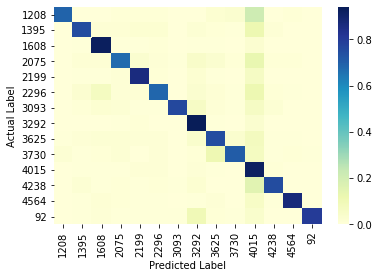

In [20]:
#test performance
def display_performance(model, test_ds, test_ds_labels, labels):
    """
    Prints accuracy and confusion matrix for specified classifier and test set.
    Displays the confusion matrix. 
    
    """

    loss, accuracy = model.evaluate(test_ds)

    print('Test Set Accuracy: ', accuracy)

    predictions = model.predict(test_ds)
    num_labels = model.get_layer(index=1).output_shape[-1]
    
    cf_matrix = np.zeros((num_labels, num_labels))
    
    for i, prediction in enumerate(predictions):
        label_actual_idx = test_ds_labels[i]
        predict_label_idx = np.argmax(prediction)
        cf_matrix[label_actual_idx, predict_label_idx] += 1
        
    cf_matrix_norm = normalize(cf_matrix, axis=1, norm='l1')

    sns.heatmap(cf_matrix_norm, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

display_performance(model, test_ds, test_data['cat_1_encoded'], le.classes_)
    